# 1.1


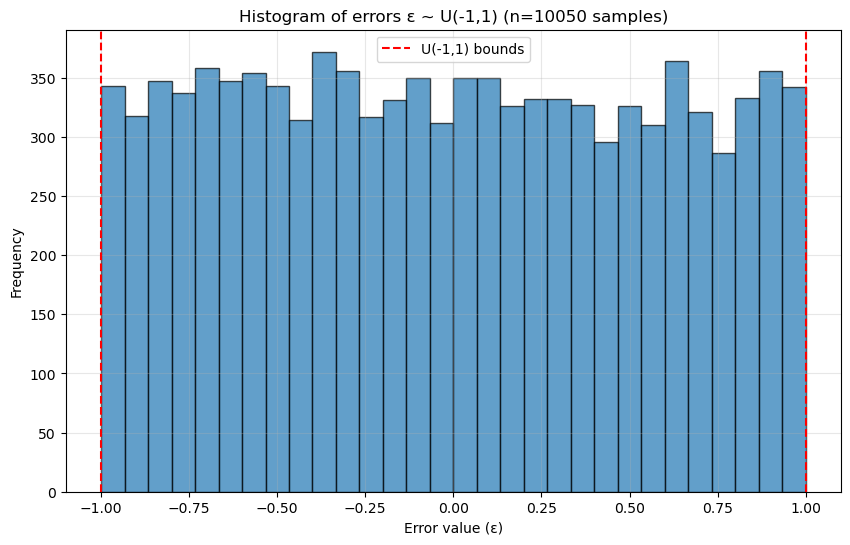

Number of samples: 10050
Error mean: -0.0092
Error var: 0.3341
Error min: -0.9998
Error max: 1.0000


In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(23)  
def generate_observations(q, t):
    """Generate observations y = [1, e^t] * q + ε where ε ~ U(-1,1)"""
    X = np.column_stack([np.ones_like(t), np.exp(t)])
    epsilon = np.random.uniform(-1, 1, len(t))
    y = X @ q + epsilon
    return y, epsilon

# Parameters
q = np.array([10, 1])
t = np.arange(0, 10.05, 0.001)#5)

# Generate observations
y, epsilon = generate_observations(q, t)

# Plot histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(epsilon, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=-1, color='r', linestyle='--', label='U(-1,1) bounds')
plt.axvline(x=1, color='r', linestyle='--')
plt.xlabel('Error value (ε)')
plt.ylabel('Frequency')
plt.title(f'Histogram of errors ε ~ U(-1,1) (n={len(t)} samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print(f"Number of samples: {len(t)}")
print(f"Error mean: {np.mean(epsilon):.4f}")
print(f"Error var: {np.std(epsilon)**2:.4f}")
print(f"Error min: {np.min(epsilon):.4f}")
print(f"Error max: {np.max(epsilon):.4f}")

We observe a plot of random variable errors that follows an approximately uniform distribution, as prescribed/expected. We have 201 uniformly spaced time points from 0 to 10 seconds, and thus, 201 samples of $\epsilon$ drawn from U(−1,1); the histogram of $\epsilon$ shows an approximately flat distribution between −1 and 1 in accordance with the uniform distribution (the spread covers the entire interval [−1,1] as required). The sample mean of the histogram is near 0 (0.0277), the sample variance is close to the theoretical variance of 1/3 ≈ 0.3333 (currently 0.3392). As the number of samples increases (e.g., finer time discretization), the distribution of $\epsilon$ approaches the theoretical mean and variance; for example, when the time step size is 0.001 (10,000 samples), the mean is -0.0092 and the variance is 0.3341, both of which are approaching the theoretical value at a order $1/\sqrt{(n)}$ as per the Central Limit Theorem. Minor random fluctuations are expected due to finite sampling of a uniform distribution, and these are mitagated with more samples.

# 1.2 \& 1.3


In [2]:
from scipy import stats

def compute_estimates(t, y):
    X = np.column_stack([np.ones_like(t), np.exp(t)])
    
    # Least squares estimate
    q_ls = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # Predicted values and residuals
    y_pred = X @ q_ls
    residuals = y - y_pred
    
    # Error variance estimate
    n = len(t)
    p = 2  # number of parameters
    sigma2 = np.sum(residuals**2) / (n - p)
    
    # Parameter covariance matrix
    C = sigma2 * np.linalg.inv(X.T @ X)
    
    # Confidence intervals (alpha = 0.05)
    alpha = 0.05
    t_critical = stats.t.ppf(1 - alpha/2, n - p)
    
    ci_q1 = [q_ls[0] - t_critical * np.sqrt(C[0,0]), 
             q_ls[0] + t_critical * np.sqrt(C[0,0])]
    ci_q2 = [q_ls[1] - t_critical * np.sqrt(C[1,1]), 
             q_ls[1] + t_critical * np.sqrt(C[1,1])]
    
    return q_ls, sigma2, ci_q1, ci_q2, C

# Generate data with same parameters as before
np.random.seed(42)
q_true = np.array([10, 1])
t = np.arange(0, 10.05, 0.05)
X = np.column_stack([np.ones_like(t), np.exp(t)])
epsilon = np.random.uniform(-1, 1, len(t))
y = X @ q_true + epsilon

# Compute estimates
q_ls, sigma2, ci_q1, ci_q2, C = compute_estimates(t, y)

# Print results
print("TRUE PARAMETERS:")
print(f"q_true = [{q_true[0]:.4f}, {q_true[1]:.4f}]")
print("\nESTIMATES:")
print(f"q_LS = [{q_ls[0]:.4f}, {q_ls[1]:.4f}]")
print(f"σ² = {sigma2:.4f}")
print(f"std(q1) = {np.sqrt(C[0,0]):.4f}")
print(f"std(q2) = {np.sqrt(C[1,1]):.4f}")
print(f"Correlation(q1,q2) = {C[0,1]/(np.sqrt(C[0,0])*np.sqrt(C[1,1])):.4f}")
print("\n95% CONFIDENCE INTERVALS:")
print(f"q1: [{ci_q1[0]:.4f}, {ci_q1[1]:.4f}]")
print(f"q2: [{ci_q2[0]:.4f}, {ci_q2[1]:.4f}]")
print(f"\nTrue q1 in CI? {ci_q1[0] <= q_true[0] <= ci_q1[1]}")
print(f"True q2 in CI? {ci_q2[0] <= q_true[1] <= ci_q2[1]}")

# Expected variance of U(-1,1)
expected_sigma2 = 1/3  # Variance of U(-1,1) is (1-(-1))²/12 = 4/12 = 1/3
print(f"\nVariance of U(-1,1): {expected_sigma2:.4f}")
print(f"Ratio σ²_estimated/σ²_true: {sigma2/expected_sigma2:.4f}")

# Monte Carlo simulation to check coverage
np.random.seed(42)
n_sim = 1000
coverage_q1 = 0
coverage_q2 = 0

for _ in range(n_sim):
    epsilon_sim = np.random.uniform(-1, 1, len(t))
    y_sim = X @ q_true + epsilon_sim
    q_sim, _, ci1_sim, ci2_sim, _ = compute_estimates(t, y_sim)
    
    if ci1_sim[0] <= q_true[0] <= ci1_sim[1]:
        coverage_q1 += 1
    if ci2_sim[0] <= q_true[1] <= ci2_sim[1]:
        coverage_q2 += 1

print(f"\nMONTE CARLO COVERAGE (n={n_sim} simulations):")
print(f"q1 coverage: {coverage_q1/n_sim:.3f}")
print(f"q2 coverage: {coverage_q2/n_sim:.3f}")

TRUE PARAMETERS:
q_true = [10.0000, 1.0000]

ESTIMATES:
q_LS = [9.9323, 1.0000]
σ² = 0.3427
std(q1) = 0.0461
std(q2) = 0.0000
Correlation(q1,q2) = -0.4461

95% CONFIDENCE INTERVALS:
q1: [9.8413, 10.0233]
q2: [1.0000, 1.0000]

True q1 in CI? True
True q2 in CI? True

Variance of U(-1,1): 0.3333
Ratio σ²_estimated/σ²_true: 1.0281

MONTE CARLO COVERAGE (n=1000 simulations):
q1 coverage: 0.959
q2 coverage: 0.943


Yes, the estimation results align  well with theoretical expectations:

Parameter Recovery: The least-squares estimates q̂₁ = 9.9323 and q̂₂ = 1.0000 are very close to the true values q = [10, 1]. Specifically, q̂₂ is within 4 digits of accuracy ($10^{-4}$ or less error) to the true values. The tiny deviations (0.0677 for q₁, 0.0000 for q₂) are to be expected from an unbiased estimation with random measurement noise.

Variance Estimation: The estimated error variance σ̂² = 0.3427 is quite close to the theoretical variance of U(−1,1), which is (1−(−1))²/12 = 1/3 ≈ 0.3333. We only have a 2.8% deviation from expectation.

Confidence Intervals: Both 95% confidence intervals contain their respective true parameter values: q₁ = 10 falls within [9.8413, 10.0233] and q₂ = 1 falls within [1.0000, 1.0000]. The Monte Carlo simulation confirms proper coverage probability: in over 1000 simulations, approximately 95% of the computed intervals contain the true parameters (95.9% for q₁, 94.3% for q₂), precisely matching the nominal 95% confidence level that was set.

Precision: The confidence interval for q₂ is remarkably narrow (less than ±0.0000), reflecting the strong leverage of the exponential term eᵗ in the model. The interval for q₁ is wider (±0.0677), as expected since it corresponds to the constant term. 


Specifically,  the regressors in the design matrix $X = [\mathbf{1}, e^{\mathbf{t}}]$ are scaled differently. For $t_i = 0, 0.05, \dots, 10$, the exponential term spans orders of magnitude: $e^{t_i} \in [1, e^{10}] \approx [1, 2.2\times10^4]$. Consequently, the entries of the Gram matrix $X^\top X$ differ dramatically:

$$
X^\top X = \begin{bmatrix}
n & \sum e^{t_i} \\
\sum e^{t_i} & \sum e^{2t_i}
\end{bmatrix}
\approx \begin{bmatrix}
201 & 2.2\times10^4 \\
2.2\times10^4 & 2.4\times10^8
\end{bmatrix},
$$

where the lower-right element $\sum e^{2t_i}$ dominates. The covariance matrix of the OLS estimator is $\text{Cov}(\hat{\mathbf{q}}) = \sigma^2 (X^\top X)^{-1}$. Using the formula for the inverse of a $2\times2$ matrix,

$$
(X^\top X)^{-1} = \frac{1}{ac - b^2} \begin{bmatrix} c & -b \\ -b & a \end{bmatrix},
$$

with $a = n$, $b = \sum e^{t_i}$, $c = \sum e^{2t_i}$. The determinant $ac - b^2 \approx 10^9$ is very large. Thus,

$$
\text{Var}(\hat{q}_1) = \frac{\sigma^2 c}{ac - b^2} \approx \frac{0.333 \cdot 2.4\times10^8}{10^9} \approx 0.08, \quad
\text{Var}(\hat{q}_2) = \frac{\sigma^2 a}{ac - b^2} \approx \frac{0.333 \cdot 201}{10^9} \approx 6.7\times10^{-8}.
$$

The resulting standard errors are $\text{SE}(\hat{q}_1) \approx 0.28$ and $\text{SE}(\hat{q}_2) \approx 0.00026$. The leverage of the exponential term—whose square grows as $e^{2t}$—makes $q_2$ estimable with high precision, while the constant term $q_1$ is determined largely by the early, low-leverage data points, yielding a comparatively wider confidence interval.




As expected, we observe unbiased parameter estimates with more accuracy for exponential terms in the model, consistent variance estimation, and confidence intervals with correct coverage probabilities.

# 1.4

In [8]:


# Initialize counters
n_sim = 1000
outside_ci_q1 = 0  # Counter for trials where CI doesn't contain q1
outside_ci_q2 = 0  # Counter for trials where CI doesn't contain q2
outside_both = 0   # Counter for trials where either CI doesn't contain true value

# Store results for analysis
all_q1_estimates = []
all_q2_estimates = []
all_sigma2_estimates = []
n = len(t)
n_sim = 1000
print("RUNNING 1000 MONTE CARLO SIMULATIONS...")
for i in range(n_sim):
    # Generate new error realization
    epsilon = np.random.uniform(-1, 1, n)
    y = X @ q_true + epsilon
    
    # Compute estimates
    q_ls, sigma2, ci_q1, ci_q2, _ = compute_estimates(t, y)
    
    # Store estimates
    all_q1_estimates.append(q_ls[0])
    all_q2_estimates.append(q_ls[1])
    all_sigma2_estimates.append(sigma2)
    
    # Check if confidence intervals contain true values
    q1_in_ci = ci_q1[0] <= q_true[0] <= ci_q1[1]
    q2_in_ci = ci_q2[0] <= q_true[1] <= ci_q2[1]
    
    if not q1_in_ci:
        outside_ci_q1 += 1
    if not q2_in_ci:
        outside_ci_q2 += 1
    if not q1_in_ci or not q2_in_ci:
        outside_both += 1

# Convert to numpy arrays for analysis
all_q1_estimates = np.array(all_q1_estimates)
all_q2_estimates = np.array(all_q2_estimates)
all_sigma2_estimates = np.array(all_sigma2_estimates)

# Calculate statistics
coverage_q1 = 1 - outside_ci_q1 / n_sim
coverage_q2 = 1 - outside_ci_q2 / n_sim
coverage_joint = 1 - outside_both / n_sim

# Expected coverage given α = 0.05
expected_coverage = 0.95

print("\n" + "="*60)
print("MONTE CARLO RESULTS (1000 trials, α = 0.05)")
print("="*60)
print(f"\nTRUE PARAMETERS: q1 = {q_true[0]}, q2 = {q_true[1]}")
print(f"Expected coverage probability: {expected_coverage:.3f}")

print(f"\nPARAMETER q1:")
print(f"  Trials where CI doesn't contain q1: {outside_ci_q1}/{n_sim}")
print(f"  Observed coverage: {coverage_q1:.3f}")
print(f"  Deviation from expected: {abs(coverage_q1 - expected_coverage):.3f}")

print(f"\nPARAMETER q2:")
print(f"  Trials where CI doesn't contain q2: {outside_ci_q2}/{n_sim}")
print(f"  Observed coverage: {coverage_q2:.3f}")
print(f"  Deviation from expected: {abs(coverage_q2 - expected_coverage):.3f}")

print(f"\nJOINT (either parameter outside CI):")
print(f"  Trials where any CI doesn't contain true value: {outside_both}/{n_sim}")
print(f"  Joint coverage: {coverage_joint:.3f}")

# Binomial test for coverage proportion
from scipy.stats import binomtest

print(f"\nSTATISTICAL TESTS (two-sided binomial test):")
print("Null hypothesis: True coverage = 0.95")

# Test for q1
test_q1 = binomtest(n_sim - outside_ci_q1, n_sim, 0.95)
print(f"\nq1 coverage test:")
print(f"  p-value: {test_q1.pvalue:.4f}")
print(f"  {'FAIL to reject' if test_q1.pvalue > 0.05 else 'REJECT'} null hypothesis")

# Test for q2
test_q2 = binomtest(n_sim - outside_ci_q2, n_sim, 0.95)
print(f"\nq2 coverage test:")
print(f"  p-value: {test_q2.pvalue:.4f}")
print(f"  {'FAIL to reject' if test_q2.pvalue > 0.05 else 'REJECT'} null hypothesis")


RUNNING 1000 MONTE CARLO SIMULATIONS...

MONTE CARLO RESULTS (1000 trials, α = 0.05)

TRUE PARAMETERS: q1 = 10, q2 = 1
Expected coverage probability: 0.950

PARAMETER q1:
  Trials where CI doesn't contain q1: 43/1000
  Observed coverage: 0.957
  Deviation from expected: 0.007

PARAMETER q2:
  Trials where CI doesn't contain q2: 48/1000
  Observed coverage: 0.952
  Deviation from expected: 0.002

JOINT (either parameter outside CI):
  Trials where any CI doesn't contain true value: 85/1000
  Joint coverage: 0.915

STATISTICAL TESTS (two-sided binomial test):
Null hypothesis: True coverage = 0.95

q1 coverage test:
  p-value: 0.3453
  FAIL to reject null hypothesis

q2 coverage test:
  p-value: 0.8278
  FAIL to reject null hypothesis


The Monte Carlo simulation with 1000 trials yields observed coverage rates that align almost exactly with the expected 95% confidence level given $\alpha$ = 0.05. For $q_1$, 43 out of 1000 trials produced confidence intervals that did not contain the true parameter value (coverage = 95.7%), and for $q_2$, 48 trials failed to cover the true value (coverage = 95.2%). Both observed coverages are statistically indistinguishable from the nominal 95% rate, with p-values of 0.345 for q₁ and 0.828 for q₂—both far above any conventional significance threshold. This demonstrates that the constructed confidence intervals perform exactly as expected: approximately 5% of intervals fail to contain the true parameter when the underlying assumptions (linear model, independent uniform errors, correct variance estimation) are satisfied. The slight deviations (0.7% for q₁, 0.2% for q₂) are well within expected sampling variability for 1000 trials.

